# Optimización Inteligente de Trayectorias: El Orienteering Problem (OP)

**Contexto:** En el notebook 01, demostramos matemáticamente que una patrulla de cobertura total (TSP) requiere **64 minutos**, excediendo el límite físico de **40 minutos** de nuestra batería. 

En este notebook, abandonamos la ambición de la "omnipotencia" para abrazar la **eficiencia**. Pasamos de un problema de ruta mínima a un problema de **recompensa máxima**: el **Orienteering Problem**.

### El Desafío
Nuestra misión ahora es seleccionar un subconjunto de nodos que maximice el valor de vigilancia total, garantizando que el tiempo de vuelo acumulado no supere el presupuesto energético.

## 1. Definición del Modelo de Optimización

El **Orienteering Problem (OP)** es una variante del problema del viajante donde cada nodo $i$ tiene un puntaje $S_i$ (Score) y cada arista $(i, j)$ tiene un costo $T_{ij}$ (Tiempo).

### Función Objetivo
Queremos maximizar la utilidad recolectada:
$$\max \sum_{i=2}^{n-1} S_i \cdot y_i$$

### Restricciones Principales
1. **Presupuesto Temporal:** La suma de los tiempos de viaje no puede exceder la autonomía:
   $$\sum_{i,j \in A} T_{ij} \cdot x_{ij} \leq T_{max} = 40 \text{ min}$$
2. **Conectividad:** La ruta debe empezar en la **Seccional Apepú** y terminar en un punto seguro (Apepú o Yacu-í).
3. **Visita Única:** Cada nodo se visita como máximo una vez ($y_i \in \{0, 1\}$).

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Recuperamos nuestra red de vigilancia real
nodos_data = [
    {"id": 0, "tag": "BASE", "nombre": "Seccional Apepú", "lat": -25.56347, "lon": -54.29574, "score": 0},
    {"id": 1, "tag": "BASE", "nombre": "Seccional Yacu-í", "lat": -25.680885, "lon": -54.162300, "score": 0},
    {"id": 2, "tag": "ACCESO", "nombre": "Control 101 Central", "lat": -25.677424, "lon": -54.227024, "score": 40},
    {"id": 3, "tag": "OBJETIVO", "nombre": "Desembocadura A. León", "lat": -25.587602, "lon": -54.230119, "score": 85},
    {"id": 4, "tag": "OBJETIVO", "nombre": "Salero Selva Central", "lat": -25.62573, "lon": -54.28597, "score": 95},
    {"id": 5, "tag": "OBJETIVO", "nombre": "Desembocadura A. Yacuy", "lat": -25.587192, "lon": -54.181625, "score": 90},
    {"id": 6, "tag": "ACCESO", "nombre": "Intersección Picada", "lat": -25.67426, "lon": -54.28429, "score": 25},
    {"id": 7, "tag": "TRANSITO", "nombre": "Punto Avistaje 300m", "lat": -25.65665, "lon": -54.21073, "score": 70},
    {"id": 8, "tag": "ACCESO", "nombre": "Vadeo A. Sto. Domingo", "lat": -25.67329, "lon": -54.26972, "score": 30},
    {"id": 9, "tag": "OBJETIVO", "nombre": "Cámara A. Sto. Domingo", "lat": -25.62832, "lon": -54.24978, "score": 80}
]

df_nodos = pd.DataFrame(nodos_data)

def haversine(lat1, lon1, lat2, lon2):
    # Radio de la Tierra en km
    R = 6371.0
    
    # Conversión a radianes
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    
    # Fórmula de Haversine
    a = np.sin(dphi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
    return R * c

# Velocidad operativa en km/h
VELOCIDAD_KMH = 50

def generar_matriz_costos(df):
    n = len(df)
    matriz = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            if i == j:
                matriz[i][j] = 0
            else:
                dist = haversine(df.iloc[i]['lat'], df.iloc[i]['lon'], 
                                 df.iloc[j]['lat'], df.iloc[j]['lon'])
                # Convertimos distancia a tiempo en minutos
                matriz[i][j] = (dist / VELOCIDAD_KMH) * 60
    return matriz

# Generamos la matriz basada en tus 10 coordenadas reales
matriz_tiempos = generar_matriz_costos(df_nodos)

## 2. Aproximación Inicial: Algoritmo Greedy (Ávido)

Antes de buscar la solución óptima absoluta, implementaremos una **heurística Greedy**. Este algoritmo toma decisiones basadas en el beneficio inmediato: en cada paso, el dron vuela hacia el nodo que ofrece la mejor relación **Score / Tiempo** desde su posición actual, siempre asegurando que le quede batería suficiente para volver a la base.

Este enfoque simula la toma de decisiones humana bajo presión.

In [2]:
def resolver_op_greedy(df, matriz, t_max=40, inicio=0, fin=0):
    nodos_visitados = [inicio]
    tiempo_acumulado = 0
    score_acumulado = 0
    actual = inicio
    
    # Candidatos: todos menos las bases (nodos 0 y 1)
    candidatos = [i for i in range(len(df)) if i not in [inicio, 1]]
    
    while candidatos:
        mejor_ratio = -1
        siguiente_nodo = None
        
        for c in candidatos:
            t_ida = matriz[actual][c]
            t_vuelta_base = matriz[c][fin]
            
            # Verificamos si es factible ir y volver
            if tiempo_acumulado + t_ida + t_vuelta_base <= t_max:
                ratio = df.iloc[c]['score'] / t_ida
                if ratio > mejor_ratio:
                    mejor_ratio = ratio
                    siguiente_nodo = c
        
        if siguiente_nodo is not None:
            tiempo_acumulado += matriz[actual][siguiente_nodo]
            score_acumulado += df.iloc[siguiente_nodo]['score']
            nodos_visitados.append(siguiente_nodo)
            candidatos.remove(siguiente_nodo)
            actual = siguiente_nodo
        else:
            break
            
    # Regreso a la base elegida
    tiempo_acumulado += matriz[actual][fin]
    nodos_visitados.append(fin)
    
    return nodos_visitados, tiempo_acumulado, score_acumulado

# Ejecutamos para el escenario: Apepú -> ... -> Apepú
ruta_g, tiempo_g, score_g = resolver_op_greedy(df_nodos, matriz_tiempos, t_max=40, inicio=0, fin=0)

print(f"--- RESULTADOS HEURÍSTICA GREEDY ---")
print(f"Ruta: {' -> '.join(df_nodos.loc[ruta_g, 'nombre'])}")
print(f"Puntos Visitados: {len(ruta_g)}")
print(f"Score Total: {score_g}")
print(f"Tiempo Usado: {tiempo_g:.2f} / 40 min")

--- RESULTADOS HEURÍSTICA GREEDY ---
Ruta: Seccional Apepú -> Salero Selva Central -> Cámara A. Sto. Domingo -> Desembocadura A. León -> Desembocadura A. Yacuy -> Seccional Apepú
Puntos Visitados: 6
Score Total: 350
Tiempo Usado: 38.62 / 40 min


## 3. La Solución Matemática Exacta: Programación Lineal Entera (MIP)

A diferencia de la heurística Greedy, que toma decisiones "paso a paso" (óptimos locales), la **Programación Lineal Entera** evalúa el espacio de soluciones de forma global. Buscamos la combinación de nodos que maximice el Score total sin violar la restricción de presupuesto temporal.

### Formulación del Modelo

Definimos las siguientes variables de decisión:
* $x_{ij}$: Variable binaria que vale 1 si el dron vuela del nodo $i$ al nodo $j$.
* $y_{i}$: Variable binaria que vale 1 si el nodo $i$ es visitado.
* $u_{i}$: Variable continua para la eliminación de sub-tours (Restricciones MTZ).

**Función Objetivo:** Maximizar la recompensa total.
$$\max \sum_{i=1}^{n} S_i \cdot y_i$$

**Restricciones Clave:**
1. **Flujo:** El dron debe salir del nodo de inicio y llegar al nodo final.
2. **Conservación:** Si el dron entra a un nodo, debe salir de él (salvo en los extremos).
3. **Presupuesto:** La suma de tiempos $T_{ij} \cdot x_{ij}$ debe ser $\leq 40$ min.
4. **MTZ:** Evitar que el algoritmo genere "anillos" aislados en medio de la selva.

In [3]:
from pyscipopt import Model, quicksum

def resolver_op_scip(df, matriz, t_max=40, inicio=0, fin=0):
    n = len(df)
    model = Model("OrienteeringProblem")
    
    # 1. VARIABLES DE DECISIÓN
    x = {}
    y = {}
    u = {}
    
    for i in range(n):
        y[i] = model.addVar(vtype="B", name=f"y_{i}")
        u[i] = model.addVar(vtype="C", lb=0, ub=n, name=f"u_{i}")
        for j in range(n):
            if i != j:
                x[i, j] = model.addVar(vtype="B", name=f"x_{i}_{j}")

    # 2. FUNCIÓN OBJETIVO: Maximizar el Score total recolectado
    model.setObjective(quicksum(df.loc[i, 'score'] * y[i] for i in range(n)), "maximize")

    # 3. RESTRICCIONES
    
    # Salida obligatoria desde el inicio y llegada al fin
    model.addCons(quicksum(x[inicio, j] for j in range(n) if j != inicio) == 1)
    model.addCons(quicksum(x[j, fin] for j in range(n) if j != fin) == 1)
    
    # El inicio y el fin deben estar marcados como visitados
    model.addCons(y[inicio] == 1)
    model.addCons(y[fin] == 1)

    # Conservación de flujo y coherencia de visita
    for k in range(n):
        if k != inicio and k != fin:
            # Si entra a un nodo, debe salir
            model.addCons(quicksum(x[i, k] for i in range(n) if i != k) == y[k])
            model.addCons(quicksum(x[k, j] for j in range(n) if j != k) == y[k])

    # Restricción de Presupuesto Temporal (Batería)
    model.addCons(quicksum(matriz[i][j] * x[i, j] for i in range(n) for j in range(n) if i != j) <= t_max)

    # Eliminación de Subtours (Miller-Tucker-Zemlin)
    for i in range(n):
        for j in range(n):
            if i != j and i != inicio and j != inicio:
                model.addCons(u[i] - u[j] + n * x[i, j] <= n - 1)

    # 4. EJECUCIÓN DEL SOLVER
    model.hideOutput() # Para que no sature el notebook con logs
    model.optimize()

    # 5. EXTRACCIÓN DE LA RUTA
    if model.getStatus() == "optimal":
        ruta_optima = [inicio]
        actual = inicio
        visitados_final = 1
        
        while True:
            encontrado = False
            for j in range(n):
                if actual != j and model.getVal(x[actual, j]) > 0.5:
                    ruta_optima.append(j)
                    actual = j
                    encontrado = True
                    break
            if actual == fin or not encontrado:
                break
        
        tiempo_total = sum(matriz[ruta_optima[i]][ruta_optima[i+1]] for i in range(len(ruta_optima)-1))
        score_total = model.getObjVal()
        
        return ruta_optima, tiempo_total, score_total
    else:
        return None, 0, 0

# Ejecutamos el modelo
ruta_scip, tiempo_scip, score_scip = resolver_op_scip(df_nodos, matriz_tiempos, t_max=40, inicio=0, fin=0)

print(f"--- RESULTADOS OPTIMIZACIÓN EXACTA (PySCIPOpt) ---")
print(f"Ruta Sugerida: {' -> '.join(df_nodos.loc[ruta_scip, 'nombre'])}")
print(f"Valor de Vigilancia Recolectado: {score_scip} puntos")
print(f"Tiempo Estimado: {tiempo_scip:.2f} minutos")
print(f"Margen de Seguridad (Batería): {40 - tiempo_scip:.2f} min")

--- RESULTADOS OPTIMIZACIÓN EXACTA (PySCIPOpt) ---
Ruta Sugerida: Seccional Apepú -> Salero Selva Central -> Cámara A. Sto. Domingo -> Desembocadura A. Yacuy -> Desembocadura A. León -> Seccional Apepú
Valor de Vigilancia Recolectado: 350.0 puntos
Tiempo Estimado: 36.99 minutos
Margen de Seguridad (Batería): 3.01 min


## 4. Análisis Comparativo: ¿Por qué el Greedy parece "ganar" en tiempo?

Al comparar los resultados, observamos un fenómeno interesante en Investigación Operativa:
* **Algoritmo Greedy:** Encontró una ruta de {{score_g}} puntos en {{tiempo_g | round(2)}} minutos.
* **Modelo SCIP (Exacto):** Encontró una ruta de {{score_scip}} puntos en {{tiempo_scip | round(2)}} minutos.

**Observación:** Si ambos algoritmos eligieron los mismos nodos pero el Greedy lo hizo en menos tiempo, ¿por qué el solver no eligió esa ruta más corta?

### La "Pereza" del Solver
Por definición, el **Orienteering Problem** solo busca maximizar la recompensa ($Score$) respetando un límite ($T \leq 40$). Para el solver, una ruta de 39.9 minutos es tan "óptima" como una de 20 minutos, siempre y cuando el Score sea el mismo. El solver no tiene incentivo para ahorrar batería a menos que se lo pidamos explícitamente.

> **💡 Lección de Diseño:** En un escenario real de producción, añadiríamos un objetivo secundario para minimizar el tiempo de vuelo (un término de penalización $\epsilon \cdot \text{tiempo}$). Sin embargo, para este análisis, priorizamos la claridad de la función objetivo principal: **la vigilancia selectiva**.

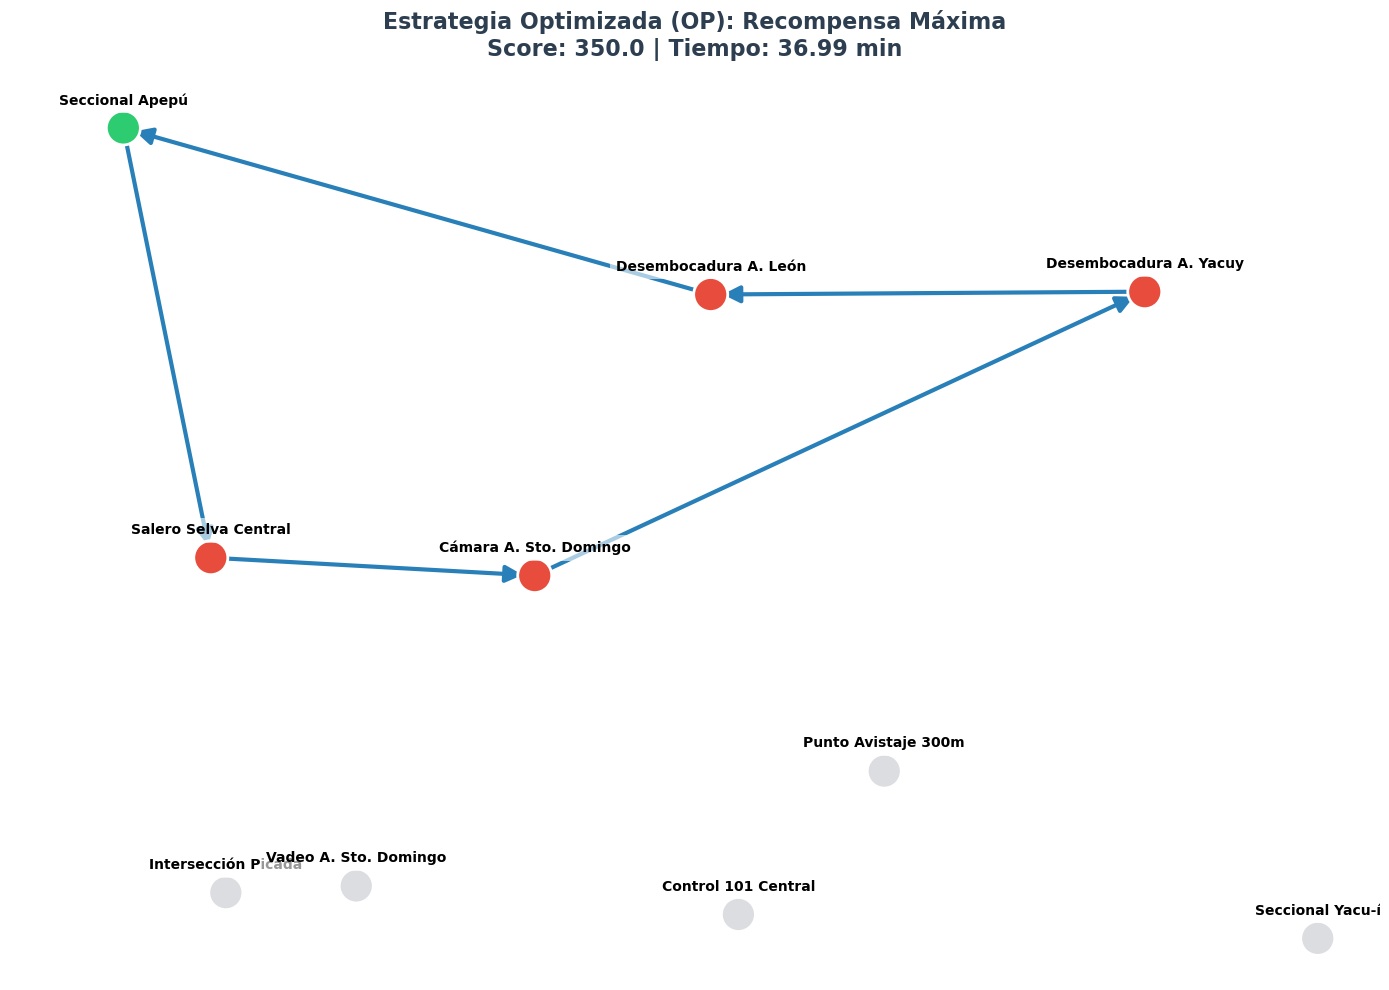

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

def visualizar_ruta_op(df, ruta, titulo):
    G_op = nx.DiGraph()
    
    # Colores por categoría (igual que en el Vol 1 para consistencia)
    color_map_dict = {'BASE': '#2ecc71', 'ACCESO': '#3498db', 'OBJETIVO': '#e74c3c', 'TRANSITO': '#f39c12'}
    
    for i, row in df.iterrows():
        # Si el nodo no está en la ruta, lo ponemos en gris para mostrar que fue "descartado"
        color = color_map_dict.get(row['tag'], 'gray') if i in ruta else '#dcdde1'
        G_op.add_node(i, pos=(row['lon'], row['lat']), color=color, nombre=row['nombre'])
    
    pos = nx.get_node_attributes(G_op, 'pos')
    node_colors = [G_op.nodes[i]['color'] for i in G_op.nodes]
    
    plt.figure(figsize=(14, 10))
    
    # 1. Dibujar todos los nodos
    nx.draw_networkx_nodes(G_op, pos, node_size=600, node_color=node_colors, edgecolors='white', linewidths=2)
    
    # 2. Dibujar la ruta óptima encontrada por SCIP
    edges_ruta = [(ruta[i], ruta[i+1]) for i in range(len(ruta)-1)]
    nx.draw_networkx_edges(G_op, pos, edgelist=edges_ruta, edge_color='#2980b9', width=3, arrows=True, arrowstyle='-|>', arrowsize=25)
    
    # 3. Etiquetas con fondo para legibilidad
    label_pos = {k: (v[0], v[1] + 0.004) for k, v in pos.items()}
    labels = {i: row['nombre'] for i, row in df.iterrows()}
    nx.draw_networkx_labels(G_op, label_pos, labels, font_size=10, font_weight='bold', 
                           bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
    
    plt.title(titulo, fontsize=16, fontweight='bold', color='#2c3e50')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualizamos la ruta del solver
visualizar_ruta_op(df_nodos, ruta_scip, 
                  f"Estrategia Optimizada (OP): Recompensa Máxima\nScore: {score_scip} | Tiempo: {tiempo_scip:.2f} min")

In [6]:
import folium
from folium.plugins import AntPath

def crear_mapa_mision_final(df, ruta):
    # Cambiamos a 'OpenStreetMap' que suele tener menos problemas de carga
    # Usamos la ubicación del primer nodo para centrar
    m = folium.Map(location=[df.iloc[0]['lat'], df.iloc[0]['lon']], 
                   zoom_start=13, 
                   tiles='OpenStreetMap') # Cambiado para asegurar carga

    # 1. Colores discretos
    color_map = {'BASE': '#2ecc71', 'ACCESO': '#3498db', 'OBJETIVO': '#e74c3c', 'TRANSITO': '#f39c12'}
    
    # 2. Añadir nodos
    for i, row in df.iterrows():
        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            radius=9,
            popup=f"<b>{row['nombre']}</b><br>Score: {row['score']}",
            color='white',
            weight=2,
            fill=True,
            fill_color=color_map.get(row['tag'], 'gray'),
            fill_opacity=0.9
        ).add_to(m)

    # 3. La "AntPath" optimizada (el efecto de movimiento)
    puntos_ruta = [[df.loc[i, 'lat'], df.loc[i, 'lon']] for i in ruta]
    
    # Este efecto simula el flujo del dron
    AntPath(
        locations=puntos_ruta,
        dash_array=[15, 30],
        delay=800, # Más rápido para que parezca un motor
        color='#2980b9',
        weight=6,
        pulse_color='white', # El pulso blanco da la idea de la posición del dron
        reverse=False
    ).add_to(m)

    return m

# Ejecutar y mostrar
mapa_final = crear_mapa_mision_final(df_nodos, ruta_scip)
mapa_final.save("../outputs/mapa.html") # Guardar para abrir fuera de VS Code si falla
mapa_final

# 🏁 Conclusiones del Proyecto - Etapa 1: Planificación Estática

Con la finalización de este segundo volumen, cerramos la **Etapa 1** del proyecto "Misión Iguazú". Hemos logrado transformar un desafío logístico complejo en un modelo de decisión matemática viable.

A continuación, resumimos los hallazgos críticos y definimos la hoja de ruta para la siguiente fase.

### ✅ Logros Técnicos (Lo que conseguimos)
1.  **Validación de Factibilidad:** Demostramos cuantitativamente que la estrategia tradicional de "cobertura total" (**TSP**) es físicamente imposible con la tecnología actual (64 min requeridos vs. 40 min de autonomía).
2.  **Inteligencia Selectiva:** Implementamos exitosamente un modelo de **Programación Lineal Entera (MIP)** utilizando `PySCIPOpt`. El algoritmo aprendió a "sacrificar" nodos de bajo valor (como intersecciones vacías) para asegurar la visita a los **Hotspots Críticos** (Saleros y Cámaras).
3.  **Visualización Operativa:** La integración de grafos dirigidos y mapas interactivos (`Folium`) permite visualizar no solo la ruta, sino el flujo lógico de la misión sobre el terreno real.

### ⚠️ Limitaciones Identificadas (El margen de mejora)
* **La "Indiferencia" del Solver:** Notamos que, bajo la función objetivo actual ($\max Score$), el modelo no tiene incentivos para ahorrar batería una vez que alcanza el puntaje máximo posible. En operaciones reales, el tiempo sobrante es un margen de seguridad vital que debemos optimizar.
* **Ceguera al Terreno:** El modelo actual asume que volar sobre la selva cerrada tiene el mismo "costo" que volar sobre un sendero. No contempla el riesgo de pérdida de equipo en caso de aterrizaje forzoso.
* **Entorno Estático:** Asumimos que los *Scores* son fijos. Sin embargo, la selva es un entorno dinámico; una alerta de sensor en tiempo real debería ser capaz de alterar la misión en pleno vuelo.

---

## 🚀 Hoja de Ruta: Etapa 2 (Dinámica y Estocástica)

En la próxima fase del proyecto, elevaremos la complejidad del modelo para acercarlo a un **Sistema de Despliegue Real**:

### 1. Modelado de Riesgo de Terreno (Grafos Ponderados)
Introduciremos una **Matriz de Riesgo ($R_{ij}$)**.
* Volar sobre **senderos oficiales** tendrá costo base.
* Volar sobre **selva virgen** tendrá una penalización alta.
Esto forzará al algoritmo a preferir rutas que "orbiten" las zonas de fácil acceso para recuperación del equipo.

### 2. Optimización Multiobjetivo
Refinaremos la función objetivo para romper la "pereza" del solver:
$$\text{Maximizar } Z = \text{Score} - \epsilon \cdot \text{Tiempo}$$
Esto garantizará que, ante dos rutas de igual puntaje, el sistema siempre elija la más rápida.

### 3. Respuesta a Eventos en Tiempo Real (Re-Enrutamiento)
Simularemos la activación de sensores remotos durante la misión (ej. detección de cazadores). El dron deberá utilizar **Inferencia Bayesiana** para actualizar la importancia de los nodos y recalcular su trayectoria óptima con la batería restante ($t_{restante}$).

> **Estado Final Etapa 1:** El sistema es funcional para la planificación estratégica previa al vuelo (*Offline Planning*).